# Euler Method 

Use straight line to replace function curve.   

In [1]:
%%HTML
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Euler_method.svg/1024px-Euler_method.svg.png"  width="200" height="200">


In [2]:
# %load cp_imports.py
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Use retina backend for better figures
%config InlineBackend.figure_format = 'retina'


## Nuclear Decay

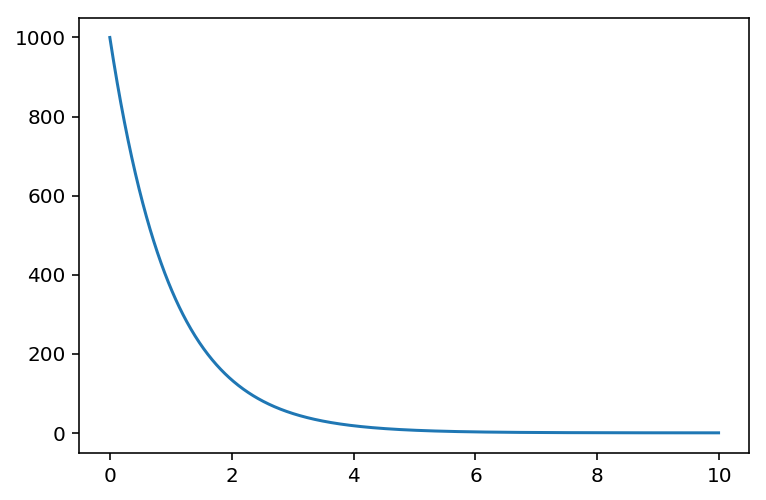

In [3]:
def euler(x, df, f0, h):
    """
    1st order ODE solver with Euler method
    
    x: varible
    df: derivative function of f
    f0: boundary condition 
    h: step 

    return function value of given x array
    """
    f = np.zeros_like(x)
    f[0] = f0
    for i in range(1, len(x)):
        # Calculate next point with backward point
        f[i] = f[i-1] + df(f[i-1]) * h
    return f


decay = lambda f: -f
h = 1e-2
x = np.arange(0, 10, h)
y = euler(x, decay, 1000, h)

plt.plot(x, y)


## Error Estimation

After every evaluation, the error will accumulate with more steps.
We can do a rough estimation about the error of this method.   
Second order error:
\begin{equation}
    O(dx^2) = \frac{d^2f}{dx^2}dx^2
\end{equation}

## Higher Order ODE

For multi-function, higher order ODE equations, we can 
create multi-dimensinal array(or array of tuple) like 1-D array.


(-0.10173759490524022, 2.1364894930100444)

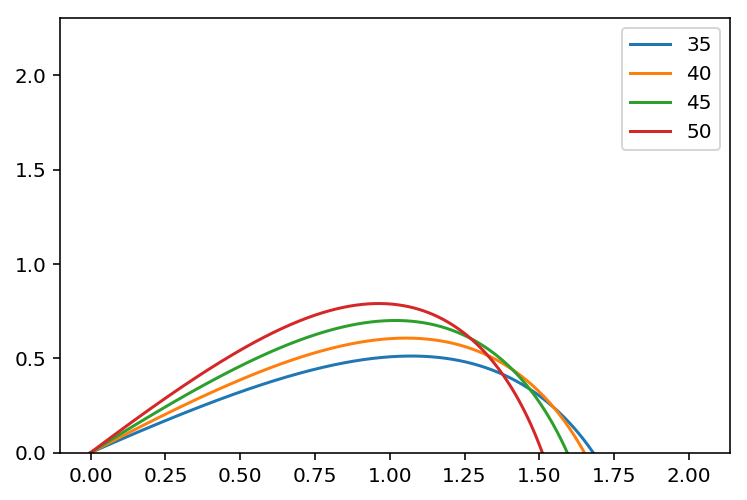

In [4]:
def multi_euler(x, df, f0, h, **args):
    """
    1st order ODE solver with Euler method
    
    x: varible
    df: derivative function of f
    f0: boundary condition 
    h: step 

    return function value of given x array
    """ 
    f = np.zeros((len(x), len(f0)))
    f[0] = f0
    for i in range(1, len(x)):
        # Calculate next point with backward point
        f[i] = f[i-1] + df(f[i-1], **args) * h
    return f


def fall_with_resistance(xs, **args):
    """
    xs: array of size 4
    xs[0]: x coordinate value
    xs[1]: y coordinate value
    xs[2]: x velocity
    xs[3]: y velocity
    """
    g = 10.
    b = 1
    x = xs[2]
    y = xs[3]
    vx = - b * (xs[2]**2 + xs[3]**2)**0.5 * xs[2]
    vy = -g - b * (xs[2]**2 + xs[3]**2)**0.5 * xs[3]
    return np.array([x, y, vx, vy])
    
    
h = 1e-3
t = np.arange(0 ,10, h)

for degree in range(35, 55, 5):
    radian = degree * np.pi / 180
    xs0 = np.array([0, 0, 10 * np.cos(radian), 10 * np.sin(radian)])
    fs = multi_euler(t, fall_with_resistance, xs0, h)
    plt.plot(fs[:, 0], fs[:, 1], label=f"{degree}")

plt.ylim(bottom=0)
plt.legend()
plt.xlim(auto=True)

##  free_pendulum

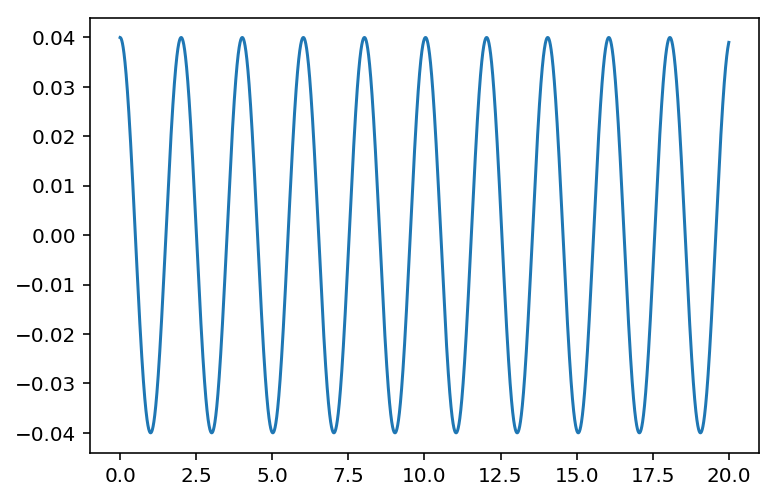

In [5]:
def free_pendulum(xs, dt=1e-3):
    """
    xs: array of size 2
    xs[0]: theta
    xs[1]: omega

    """
    g = 9.8 
    l = 1 # Unit: m
    omega = -g / l * xs[0]      
    theta = xs[1] + omega * dt  
    return np.array([theta, omega])


h = 1e-3
t = np.arange(0, 20, h)
xs0 = np.array([0.04, 0]) # Radian
fs = multi_euler(t, free_pendulum, xs0, h, dt=h)

plt.plot(t, fs[:, 0])


# Runge-Kutta Method 4-order(RK4)

Use middle point average value to calculate next point.
RK4 is the most commonly used algorithm, which introduces
truncation error on the order of $O(h^5)$,  while the total accumulated error is on the order of $O(h^{4})$.   


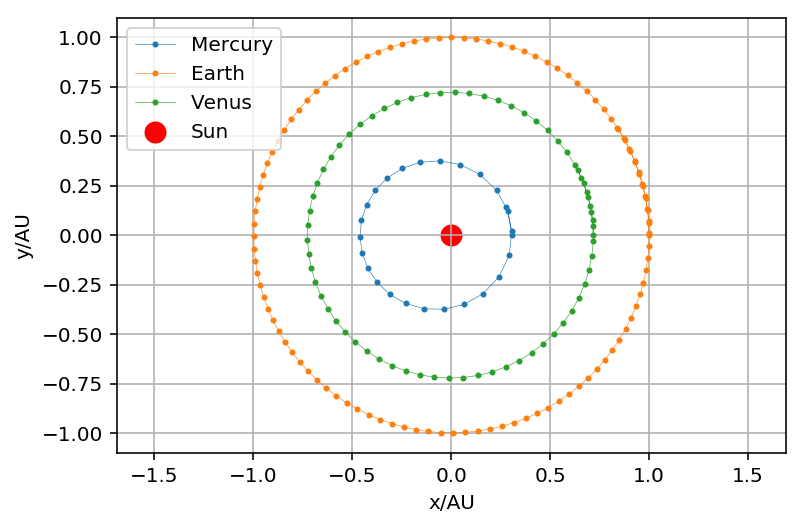

In [6]:
def rk4(t, df, f0, h, **args):
    """
    Use RK4 method to solve ode
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of RK4
    
    """
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 2-D array 
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0
    
    for i in range(1, sample_n):
        # In function df, separate independent variable and function f
        dx1 = df(t0, f0, **args) * h
        dx2 = df(t0 + 0.5 * h, f0 + 0.5 * dx1, **args) * h
        dx3 = df(t0 + 0.5 * h, f0 + 0.5 * dx2, **args) * h
        dx4 = df(t0 + h, f0 + dx3, **args) * h
        f0 += 1/6 * dx1 + 1/3 * dx2 + 1/3 * dx3 + 1/6 * dx4
        f[i] = f0
        t0 += h
        
    return f


def planet_newton(t, f):
    """
    EOM of planet in solar system with classical mechanic theory
    
    t: time Unit: s
    f: motion parameters, x, vx, y, vy 
    
    return: the difference of f
    """
    # Unpack parameters for computation convenience
    x, vx, y, vy = f
    r = (x**2 + y**2)**0.5
    GM_sun = (2. * np.pi)**2
    return np.array([vx, -GM_sun * x / r**3, \
                     vy, -GM_sun * y / r**3])


h = 1e-2

planets = {"Mercury": [0.307, 0, 0, 12.43, 0.240846],
           "Earth": [1, 0, 0, 6.28, 1], 
           "Venus": [0.718, 0, 0, 7.43779, 0.615198]}
data = pd.DataFrame.from_dict(planets, orient='index')

# Plot planet orbits
for index, row in data.iterrows(): 
    f = rk4((0, 1.1*row[4]), planet_newton, row[:4], h)
    plt.plot(f[:, 0], f[:, 2], marker='o', markersize=2, label=index, linewidth=.3)
    
# Plot sun 
plt.scatter(0, 0, marker='o', color='red', s=100, label='Sun')

plt.axis("equal")
plt.grid(True)
plt.xlabel("x/AU")
plt.ylabel("y/AU")
plt.legend()


# Adaptive RK Alogrithm(RK45)

Use higher order alogrithm to calculate error(estimation error).
Change step size according to estimation and user-defined threshold.

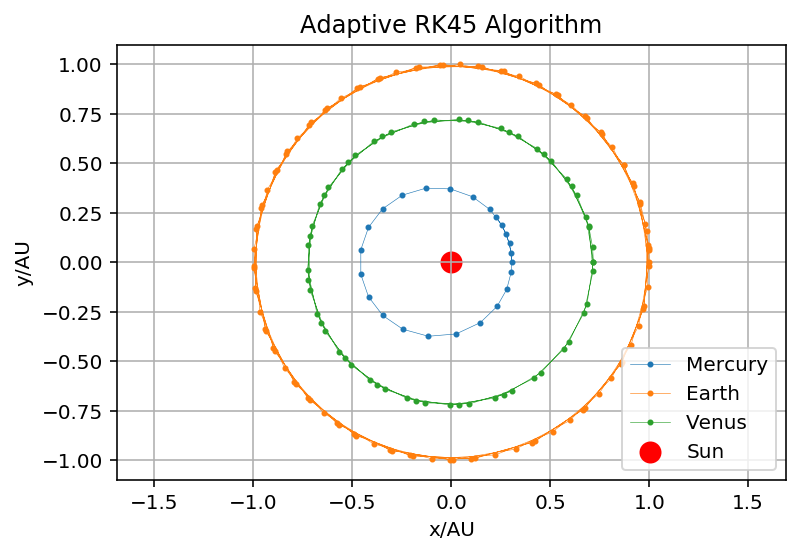

In [7]:
def rk45(t, df, f0, h, abserr=1e-5, relerr=1e-6, **args):
    """
    Use RK45 method to solve ode with adpative step size
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of RK4
    abserr: absolute error 
    relerr: relative error 
    
    """
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 2-D array 
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0
    
    # Create coefficient arrays
    # Add 0 terms for sum convenience
    a = np.array([0, 1/5, 3/10, 3/5, 1, 7/8])
    b = np.array([[0, 0, 0, 0, 0, 0], 
                  [1/5, 0, 0, 0, 0, 0], 
                  [3/40, 9/40, 0, 0, 0, 0], 
                  [3/10, -9/10, 6/5, 0, 0, 0], 
                  [-11/54, 5/2, -70/27, 35/27, 0, 0], 
                  [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096, 0]])
    # Transpose b and add newaxis for broadcast
    b = b.T[:, :, np.newaxis]
    c = np.array([37/378, 0, 250/621, 125/594, 0, 512/1771])
    d = np.array([2825/27648, 0, 18575/48384, 13525/55296, 277/14336, 1/4])
    
    # Create empty difference array for storing temp variables
    dfs = np.zeros((6, len(f0)))
    
    # Create loop variable i with initial value 1
    i = 1
    while i < sample_n:
        # In function df, separate independent variable and function f
        # Calculate dx1, dx2, ..., dx6, stored in a 6xN array
        for j in range(6):
            dfs[j] = h * df(t+a[j]*h, f0+np.sum(b[:,j,:]*dfs, axis=0))
        f4 = f0 + np.sum(d.T[:, np.newaxis] * dfs, axis=0)
        f5 = f0 + np.sum(c.T[:, np.newaxis] * dfs, axis=0)

        err_limit = abserr + relerr * max(abs(f0))
        err_current = max(abs(f4 - f5))
        # Adjust h according to current error
        if err_current > err_limit:
            # Loop until error is samller than limitation
            h = h * 0.9 *(err_limit/err_current)**(1/5)
        else: 
            # Error condition satisfied, continue iteration
            # Reset dfs to zero
            dfs.fill(0)
            f[i] = f5
            f0 = f5
            t0 += h
            h *= 1.5
            i += 1
            
    return f


h = 1e-2

planets = {"Mercury": [0.307, 0, 0, 12.43, 0.240846],
           "Earth": [1, 0, 0, 6.28, 1], 
           "Venus": [0.718, 0, 0, 7.43779, 0.615198]}
data = pd.DataFrame.from_dict(planets, orient='index')

# Plot planet orbits
for index, row in data.iterrows(): 
    f = rk45((0, row[4]), planet_newton, row[:4], h)
    plt.plot(f[:, 0], f[:, 2], marker='o', markersize=2, label=index, linewidth=.3)
    
# Plot sun 
plt.scatter(0, 0, marker='o', color='red', s=100, label='Sun')

plt.axis("equal")
plt.grid(True)
plt.xlabel("x/AU")
plt.ylabel("y/AU")
plt.title("Adaptive RK45 Algorithm")
plt.legend()


# Leapfrog Method

* Time reversibility 
* Second order

(From [wikipedia](https://en.wikipedia.org/wiki/Leapfrog_integration))
\begin{aligned}
a_{i}&=F(x_{i}),\\
v_{i+1/2}&=v_{i-1/2}+a_{i}\,\Delta t,\\
x_{i+1}&=x_{i}+v_{i+1/2}\,\Delta t,
\end{aligned} 
Introduce a temp variable to jump half-integer multiple of h every time.

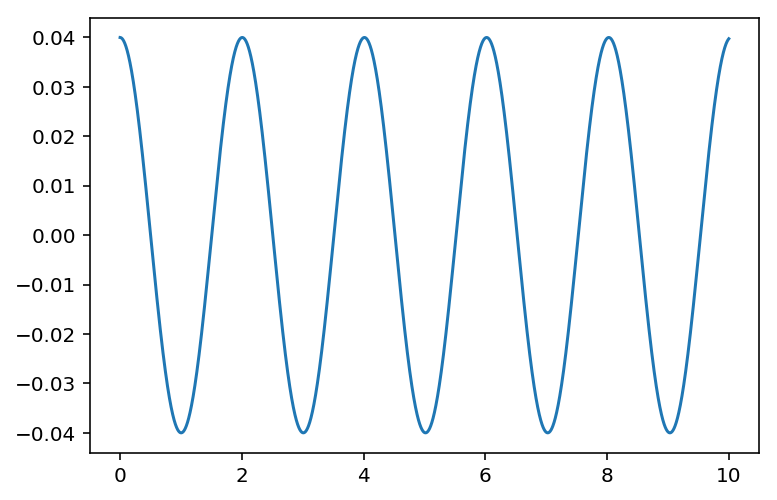

In [8]:
def leapfrog(t, df, f0, h):
    """
    Use leapfrog method to solve ode 
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of leap jump
    
    """
    t0, t1 = t
    sample_n = int((t1 - t0)/h)
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0
    mid_point = f0 + 1/2 * h * df(t0, f0)  

    for i in range(1, sample_n):
        f[i] = f[i-1] + h * df(t0+h/2, mid_point)
        t0 += h
        # Set f[i+1] new mid point
        mid_point = f[i]
    
    return f


def free_pendulum(t, xs, dt=1e-3):
    """
    xs: array of size 2
    xs[0]: theta
    xs[1]: omega

    """
    g = 9.8 
    l = 1 # Unit: m
    omega = -g / l * xs[0]      
    theta = xs[1] + omega * dt  
    return np.array([theta, omega])


h = 1e-3
xs0 = np.array([0.04, 0]) # Radian
fs = leapfrog((0, 10), free_pendulum, xs0, h)
t = np.arange(0, 10, h)

plt.plot(t, fs[:, 0])

# Verlet Method

* Frequently used in calculating EOM, namely, 2nd-order ODE
* Calculate slope at half-integer points.  
* Calculate function value at integer points.
* Order of error : $O(t^2)$  

Where Euler's method uses the forward difference approximation to the first derivative in differential equations of order one, Verlet integration can be seen as using the central difference approximation to the second derivative:

In [9]:
def verlet(t, d2f, f0, v0, h):
    """
    Use verlet method to solve ode 
    
    t: tuple, start and stop values of variables
    df: second order derivative function of f, function of t and f
    f0: boundary condition for f
    v0: initial velocity of f0
    h: step size 
    
    """
    t0, t1 = t
    sample_n = int((t1 - t0)/h)
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0  
    v0 = v0 + 0.5 * h * d2f(t0, f[0])

    for i in range(1, sample_n):
        f[i] = f[i-1] + v0 * h
        v0 = v0 + 0.5 * h * d2f(t0, f[i])
        t0 += h
    
    return f



# Bulirsch-Stoer Method

* Suitable for smooth functions
* Use different step size to extrapolate an accurate solution 
* Polynomial or rational functions to fit result
* Typical values for sample number $\{2, 4, 6, 8, \cdots\}$
* After each extrapolation, the order of error increases by 1

## Belousov-Zhabotinsky Chain Reaction

B-Z chain reaction is one of a class of
reactions that serve as a classical example of non-equilibrium
thermodynamics, resulting in the establishment of
a nonlinear chemical oscillator. Put it another way, for a chemical
reaction, it can stay at such kind of oscillation. 

# Boundary Condition 

Besides initial value problem, another well
studied problem is boundary condition problem.


## Shooting Method

Try different initial values until the
result satisfies given boundary condition.
In another perspective, convert a boundary
problem into finding root of a function.
So combine two of ODE solver and root finding
function to solve a boundary problem through
fshooting method.

In [177]:
from scipy.constants import electron_mass, hbar, e, electron_volt
from functools import partial


def shooting_1D(t, ft, guess, integrand, tol=1e-6*electron_volt, **kwargs):
    """
    Solve 1D boundary condition of ODE with shooting method. 
    Use RK4 for ODE solving, bisection search for root finding 
    
    t: time t when the conditon should be satisfied 
    ft: boundary condition at time t
    guess: tuple, initial range for searching 
    integrand: function calculates ft 
    tol: error tolerence of final result 
    
    """
    root1, root2 = guess
    # Decorate rk4 to a judge function for evaluating
    # More refinement is needed here, still have issues dealing with limit of integration
    judge = lambda q: rk4_only_end((0, t), schrodinger_1D,\
                               h=wall_width/1e3, energy=q, **kwargs)[0]

    if judge(root1) * judge(root2) > 0:
        raise ValueError("Bad guess, fail to solve.")
    
    # Use bisection method to search excpeting parameter 
    while abs(root1 - root2) > tol:
        root_mid = (root1 + root2) / 2
        if judge(root1) * judge(root_mid) < 0:
            root2 = root_mid
        else:
            root1 = root_mid
    
    return  (root1 + root2) / 2


def schrodinger_1D(x, f, **kwargs):
    """
    Calculate derivative 1-D Schrodinger function 
    
    x: position Unit: m
    f: motion paramter array, [psi, phi]
    kwargs: should potential function, return V(x) by x
            current energy of the system
    """
    # Assign function to calculate potential energy at x  
    potential = kwargs["potential"] 
    # Get current energy of system
    energy = kwargs["energy"]
    psi, phi = f
    dphi = 2 * m / hbar**2 * (potential(x) - energy) * psi
    return np.array([phi, dphi], dtype="float")
    

def infinite_wall(x):
    """
    Potential function an infinite wall at x=0 and L
    """
    if x < 0 or x > wall_width:
        return np.inf
    else:
        return 0
    

def rk4_only_end(t, df, f0, h, **args):
    """
    Use RK4 method to solve ode, only return end point value
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of RK4
    
    """
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 1-D array 
 
    for i in range(1, sample_n):
        # In function df, separate independent variable and function f
        dx1 = df(t0, f0, **args) * h
        dx2 = df(t0 + 0.5 * h, f0 + 0.5 * dx1, **args) * h
        dx3 = df(t0 + 0.5 * h, f0 + 0.5 * dx2, **args) * h
        dx4 = df(t0 + h, f0 + dx3, **args) * h
        f0 += 1/6 * dx1 + 1/3 * dx2 + 1/3 * dx3 + 1/6 * dx4
        t0 += h
        
    return f0

    
# Set some global variables here
wall_width = 5.2918e-11 # Unit: m
m = electron_mass # Unit: kg
    
# To find eigenvalues of 1-D infinite wall,
# we search energy for psi(x=L)=0
# f0 = [0, 1] as initial value for solving 1-D infinite wall problem
guess = np.array([300., 600.]) * electron_volt
ground_energy = shooting_1D(wall_width, 0, guess, schrodinger_1D,\
                            f0=[0, 1], potential=infinite_wall)
print(f"ground energy: {ground_energy/electron_volt:.4F}eV")


ground energy: 538.2014eV


Text(0.5, 1.0, '$\\psi_2(x)$')

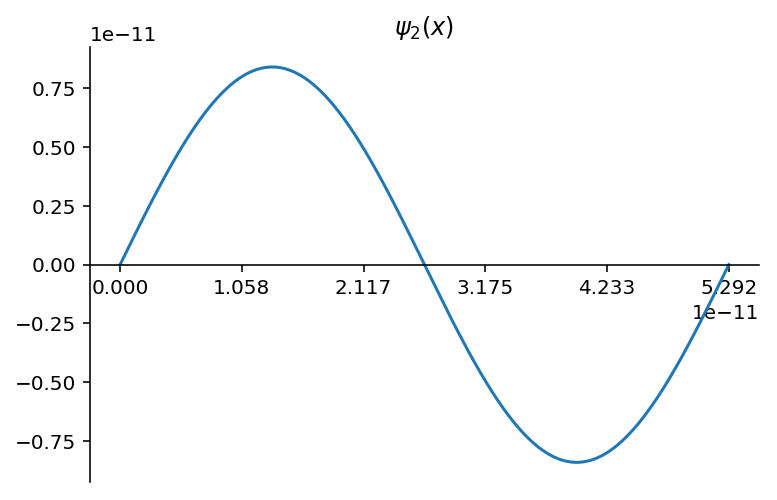

In [198]:
position = np.linspace(0, wall_width, 1000)
fs = rk4((0, wall_width), schrodinger_1D, [0, 1],\
         h=wall_width/1e3, energy=ground_energy, potential=infinite_wall)

plt.plot(position, fs[:, 0])
plt.gca().spines["bottom"].set_position(("data", 0))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xticks(np.arange(0, 1.1, 0.2) * wall_width)
plt.title(r"$\psi_2(x)$")

In [165]:
es = np.linspace(0, 1e4, 1000) * electron_volt
judge = lambda q: rk4_only_end((0, wall_width), schrodinger_1D, [0, 1], \
                               h=wall_width/1e4, energy=q, potential=infinite_wall)[0]
phi_L = np.array([judge(i) for i in es])

(0, 10500.0)

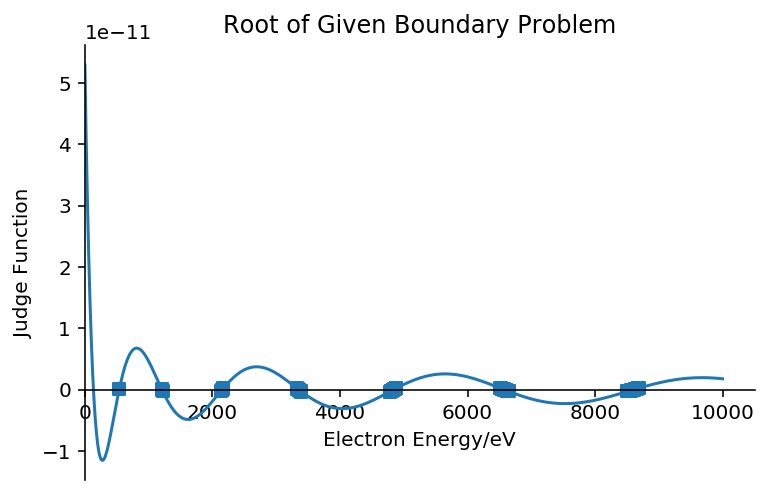

In [199]:
energy_level_mask = (abs(phi_L) < 200 * min(abs(phi_L)))

plt.plot(es/electron_volt, phi_L)
plt.scatter(es[energy_level_mask] / electron_volt, phi_L[energy_level_mask])
plt.gca().spines["bottom"].set_position(("data", 0))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title("Root of Given Boundary Problem")
plt.xlabel("Electron Energy/eV")
plt.ylabel("Judge Function")
plt.xlim(0, )
